In [7]:
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 把 Agent 的定义放在这里

In [8]:
import numpy as np
import gymnasium as gym
from collections import defaultdict

class DiscreteQlearningAgent:
    def __init__(self, env: gym.Env, learning_rate: float=0.01,
                 epsilon_start: float=1.0, epsilon_decay: float=0.005, epsilon_end: float=0.05,
                   discounted_factor: float=0.99):
        self.env = env
        self.lr = learning_rate

        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_end = epsilon_end

        self.discounted_factor = discounted_factor
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

    def get_action(self, obs) -> int:
        """
        Return random action with probability 'epsilon' and return argmax_a Q(obs, a) otherwise.
        """
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_values[obs]))

    def update(self, obs, action: int, reward: float, terminated: bool, next_obs):
        td_target = reward + (not terminated) * self.discounted_factor * np.max(self.q_values[next_obs])
        td_error = td_target - self.q_values[obs][action]
        self.q_values[obs][action] = self.q_values[obs][action] + self.lr * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)

In [41]:
from collections import OrderedDict
import numpy as np
import torch
import gymnasium as gym
from typing import Dict, Tuple, List

############################################
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def sample_trajectory(
    env: gym.Env, agent, max_length: int) -> Dict[str, np.ndarray]:
    """Sample a rollout in the environment from a policy."""
    ob, info = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        action = agent.get_action(ob)

        next_ob, reward, terminated, truncated, info = env.step(action)

        steps += 1
        done: bool = (terminated or truncated or steps >= max_length)

        obs.append(ob)
        acs.append(action)
        rewards.append(reward)
        next_obs.append(next_ob)
        terminals.append(done)

        ob = next_ob 

        if done:
            break

    return {
        "observation": np.array(obs, dtype=np.float32),
        "reward": np.array(rewards, dtype=np.float32),
        "action": np.array(acs, dtype=np.float32),
        "next_observation": np.array(next_obs, dtype=np.float32),
        "terminal": np.array(terminals, dtype=np.float32),
    }

def sample_trajectories(
    env: gym.Env,
    agent,
    min_timesteps_per_batch: int,
    max_length: int
) -> Tuple[List[Dict[str, np.ndarray]], int]:
    """Collect rollouts using policy until we have collected min_timesteps_per_batch steps."""
    timesteps_this_batch = 0
    trajs = []
    while timesteps_this_batch < min_timesteps_per_batch:
        # collect rollout
        traj = sample_trajectory(env, agent, max_length)
        trajs.append(traj)

        # count steps
        timesteps_this_batch += get_traj_length(traj)
    return trajs, timesteps_this_batch

def sample_n_trajectories(
    env: gym.Env, agent, ntraj: int, max_length: int):
    """Collect ntraj rollouts."""
    trajs = []
    for _ in range(ntraj):
        # collect rollout
        traj = sample_trajectory(env, agent, max_length)
        trajs.append(traj)
    return trajs

def convert_listofrollouts(trajs):
    """
    Take a list of rollout dictionaries and return separate arrays, where each array is a concatenation of that array
    from across the rollouts.
    """
    observations = np.concatenate([traj["observation"] for traj in trajs])
    actions = np.concatenate([traj["action"] for traj in trajs])
    next_observations = np.concatenate([traj["next_observation"] for traj in trajs])
    terminals = np.concatenate([traj["terminal"] for traj in trajs])
    concatenated_rewards = np.concatenate([traj["reward"] for traj in trajs])
    unconcatenated_rewards = [traj["reward"] for traj in trajs]
    return (
        observations,
        actions,
        next_observations,
        terminals,
        concatenated_rewards,
        unconcatenated_rewards,
    )

def get_traj_length(traj):
    return len(traj["reward"])

def from_numpy(*args, **kwargs):
    return torch.from_numpy(*args, **kwargs).float().to(device)

def to_numpy(tensor: torch.Tensor):
    return tensor.to('cpu').detach().numpy()

In [51]:
env = gym.make('FrozenLake-v1')
agent = DiscreteQlearningAgent(env)
test, _ = sample_trajectories(env, agent, 11, 100)
convert_listofrollouts(test)

(array([0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4.,
        4.], dtype=float32),
 array([1., 2., 2., 3., 3., 3., 0., 0., 3., 0., 3., 2., 0., 0., 0., 0., 1.,
        3.], dtype=float32),
 array([1., 5., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 4.,
        5.], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=float32),
 [array([0., 0.], dtype=float32),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        dtype=float32)])

# 实验

In [5]:
env = gym.make('FrozenLake-v1')
agent = DiscreteQlearningAgent(env)

total_episodes = 300_000
scores = []
avg_scores_thousand_episodes = []

for episode in tqdm(range(1, total_episodes + 1)):
    score = 0
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        score += reward

        obs = next_obs

    agent.decay_epsilon()
    scores.append(score)
    if episode % 1000 == 0:
        avg_scores_thousand_episodes.append(sum(scores) / len(scores))
        scores = []

  0%|          | 0/300000 [00:00<?, ?it/s]

100%|██████████| 300000/300000 [02:28<00:00, 2020.32it/s]


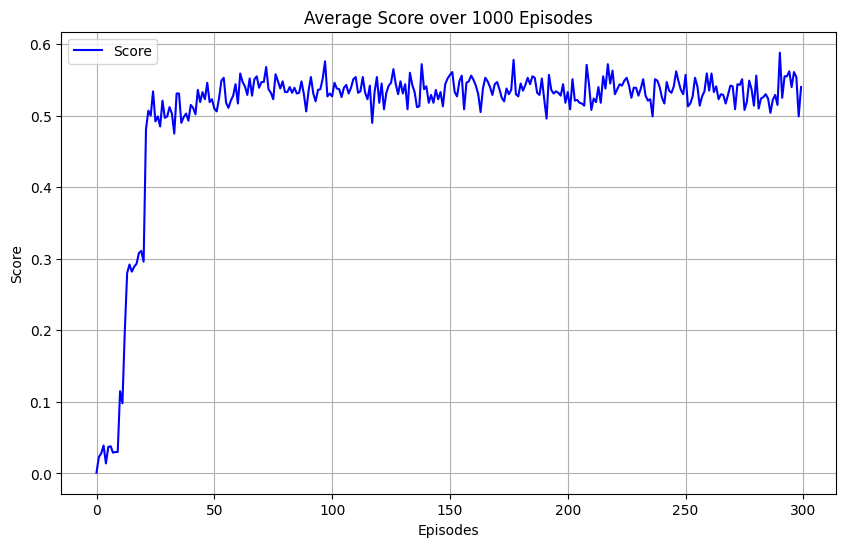

In [6]:
episodes = range(len(avg_scores_thousand_episodes))

# 创建图像
plt.figure(figsize=(10, 6))
plt.plot(episodes, avg_scores_thousand_episodes, 'b-', label='Score')

# 设置标签和标题
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over 1000 Episodes')
plt.grid(True)
plt.legend()

# 显示图像
plt.show()

